<a href="https://colab.research.google.com/github/Raihan4520/MediaPipe-Python/blob/main/Pose_Landmark_Detection_Using_MediaPipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Landmark Detection & Segmentation Mask Using **MediaPipe** (Python)

# Using lower-level API, which is more flexible and gives more control but requires more manual setup.

In [1]:
# Install necessary libraries
!pip install -q mediapipe opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [2]:
# Import required libraries
import os
import cv2
import zipfile
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Define the path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/Pose_Landmark_Detection_MediaPipe/Images.zip'

# Extract the zip file from Google Drive
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('/content/')  # Extract to the content directory

# Check if images are successfully extracted
image_folder = '/content/Images'
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Extracted Images: {image_files}")


Extracted Images: ['lisa-van-vliet-SQBe0Fvv3f0-unsplash-min.jpg', 'jahanzeb-ahsan-dxSxwlsPUHw-unsplash-min.jpg', 'jahanzeb-ahsan-K2qR1YiASyw-unsplash-min.jpg', 'jahanzeb-ahsan-gwgojUR4vFA-unsplash-min.jpg', 'declan-sun-ZEPnlMO2pVw-unsplash-min.jpg', 'blessing-olarewaju-ST_4Rw_8rxA-unsplash-min.jpg', 'marie-michele-bouchard-J_zYSwczKYA-unsplash-min.jpg', 'alena-plotnikova-LETqxKnPzoA-unsplash-min.jpg', 'jahanzeb-ahsan-O8OIs5l7--Q-unsplash-min.jpg', 'jahanzeb-ahsan-N1PLFbB1iK8-unsplash-min.jpg']


In [5]:
# Set up MediaPipe for pose estimation and segmentation
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Initialize the pose estimator
pose = mp_pose.Pose(
  static_image_mode=True,        # For static images
  model_complexity=2,            # Higher model complexity for better accuracy
  enable_segmentation=True,      # Enable segmentation
  min_detection_confidence=0.5)  # Minimum confidence threshold for pose detection


In [6]:
# Function to visualize pose landmarks
def get_pose_visualization(image, results):
  annotated_image = image.copy()
  mp_drawing.draw_landmarks(
    annotated_image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=8, circle_radius=10),  # Thicker landmarks
    mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=6, circle_radius=6))   # Thicker connections
  return annotated_image

# Function to visualize pose segmentation mask
def get_segmentation_visualization(image, results):
  condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = (0, 255, 0)  # Green background for segmentation
  segmented_image = np.where(condition, image, bg_image)
  return segmented_image


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


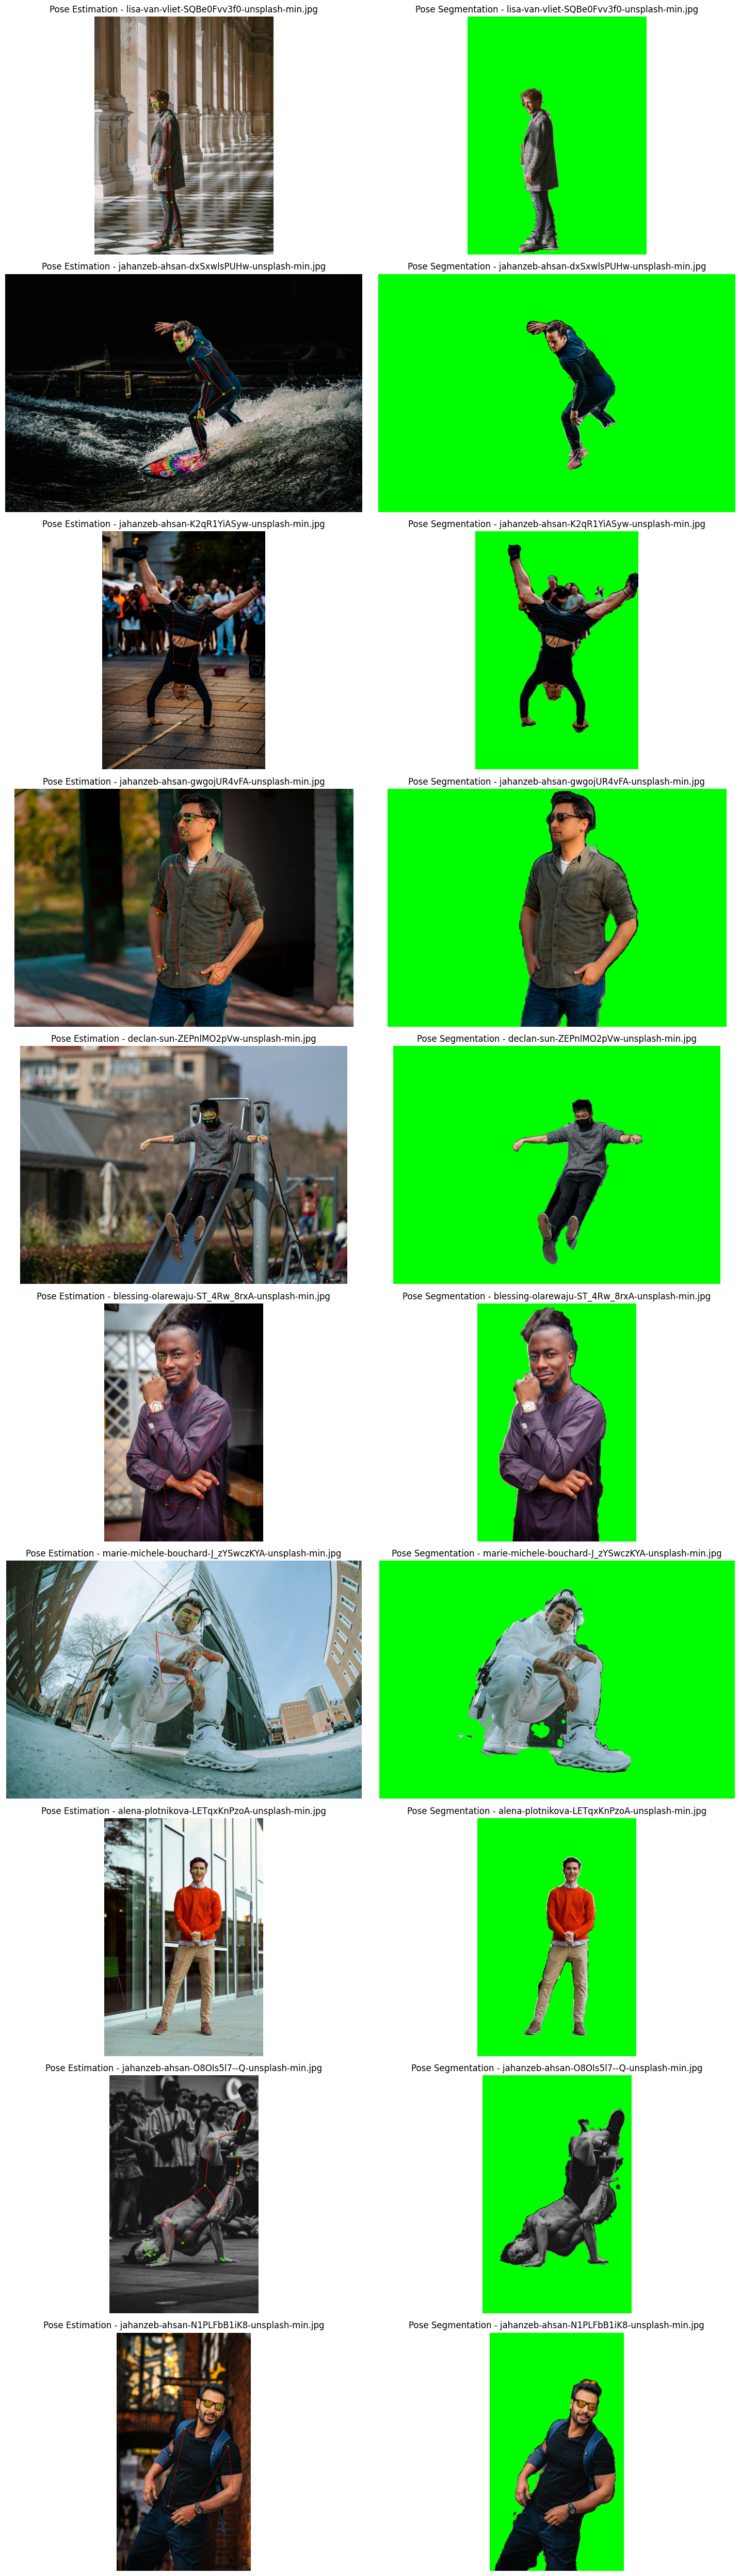

In [7]:
# Visualize each image in a row (2 columns: pose, segmentation)
fig, axs = plt.subplots(len(image_files), 2, figsize=(15, len(image_files) * 5))

for i, image_file in enumerate(image_files):
  image_path = os.path.join(image_folder, image_file)
  image = cv2.imread(image_path)

  # Convert the BGR image to RGB for MediaPipe
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Perform pose estimation
  results = pose.process(image_rgb)

  # Check if pose landmarks were detected
  if results.pose_landmarks:
    # Get the pose and segmentation visualizations
    pose_image = get_pose_visualization(image, results)
    if results.segmentation_mask is not None:
      segmentation_image = get_segmentation_visualization(image, results)

    # Display pose estimation (Left Column)
    axs[i, 0].imshow(cv2.cvtColor(pose_image, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title(f"Pose Estimation - {image_file}")
    axs[i, 0].axis('off')

    # Display pose segmentation (Right Column)
    axs[i, 1].imshow(cv2.cvtColor(segmentation_image, cv2.COLOR_BGR2RGB))
    axs[i, 1].set_title(f"Pose Segmentation - {image_file}")
    axs[i, 1].axis('off')
  else:
    print(f"Pose not detected in {image_file}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Close the pose object
pose.close()


# Using newer, higher-level API designed to handle common tasks with more simplicity and fewer lines of code.

In [8]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [9]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/1/pose_landmarker_lite.task

In [10]:
import math

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


Pose Estimation - lisa-van-vliet-SQBe0Fvv3f0-unsplash-min.jpg


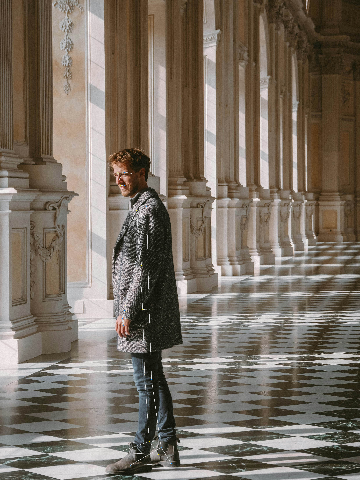

Pose Segmentation - lisa-van-vliet-SQBe0Fvv3f0-unsplash-min.jpg


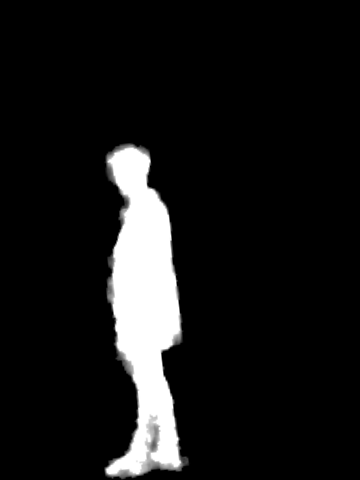

Pose Estimation - jahanzeb-ahsan-dxSxwlsPUHw-unsplash-min.jpg


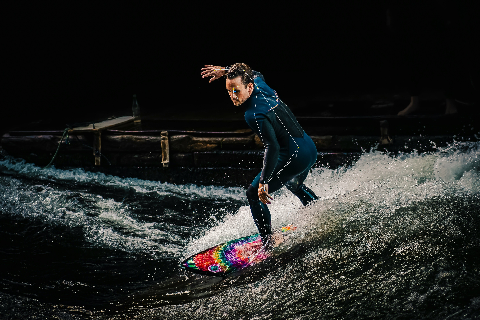

Pose Segmentation - jahanzeb-ahsan-dxSxwlsPUHw-unsplash-min.jpg


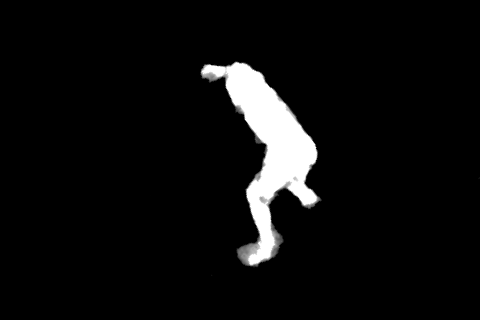

In [11]:
# STEP 1: Import the necessary modules.
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
for image_file in image_files[:2]: # Visualising only 2 images for simplicity
  image_path = os.path.join(image_folder, image_file)
  image = mp.Image.create_from_file(image_path)

  # STEP 4: Detect pose landmarks from the input image.
  detection_result = detector.detect(image)

  # STEP 5: Process the detection result. In this case, visualize it.
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
  print(f"Pose Estimation - {image_file}")
  resize_and_show(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

  segmentation_mask = detection_result.segmentation_masks[0].numpy_view()
  visualized_mask = np.repeat(segmentation_mask[:, :, np.newaxis], 3, axis=2) * 255
  print(f"Pose Segmentation - {image_file}")
  resize_and_show(visualized_mask)
